In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import networkx
from scipy.sparse import csr_matrix
import collections
import matplotlib.pyplot as plt

In [2]:
path = "../original_data/Cooffending/Cooffending.csv"
df = pd.read_csv(path)

In [3]:
id_2_index = {OffenderIdentifier: i for i, OffenderIdentifier in enumerate(df.OffenderIdentifier.unique())}
index_2_id = {i: OffenderIdentifier for i, OffenderIdentifier in enumerate(df.OffenderIdentifier.unique())}
cid_2_cindex = {CrimeIdentifier: i for i, CrimeIdentifier in enumerate(df.CrimeIdentifier.unique())}
cindex_2_cid = {i: CrimeIdentifier for i, CrimeIdentifier in enumerate(df.CrimeIdentifier.unique())}

In [4]:
df["index"] = df["OffenderIdentifier"].map(id_2_index)
df["cindex"] = df["CrimeIdentifier"].map(cid_2_cindex)
print(df.head(10))

   OffenderIdentifier OffenderGender  CrimeIdentifier  CrimeType1  CrimeType2  \
0                   1              F          1085034      3530.0         NaN   
1                   2              F          1431379      1430.0         NaN   
2                   4              M           167174      1430.0     21702.0   
3                   5              M          1179096      1420.0         NaN   
4                  17              M          1270690      1625.0         NaN   
5                  38              M           356360      1330.0         NaN   
6                  39              M          1171604     21405.0         NaN   
7                  40              M           852956      3520.0         NaN   
8                 149              M           806220      1420.0         NaN   
9                 231              M           778217     21405.0         NaN   

   CrimeType3  CrimeType4  Municipality  CrimeLocation  NumberYouthOffenders  \
0         NaN         NaN   

In [5]:
dfs = {}
for y in range(2003,2011):
    dfs[y] = df[df["CrimeYear"] == y]


In [6]:
index_crimeid_csrmatrix = {}
adjacency_csrmatrix = {}
for y in range(2003,2011):
    row = dfs[y]['index'].values
    col = dfs[y]['cindex'].values
    val = np.ones(row.shape[0])
    index_crimeid_csrmatrix[y] = csr_matrix((val, (row, col)), shape=(row.max()+1, col.max()+1))
    adjacency_csrmatrix[y] = index_crimeid_csrmatrix[y] @ index_crimeid_csrmatrix[y].T
    adjacency_csrmatrix[y][adjacency_csrmatrix[y] > 0] = 1
    adjacency_csrmatrix[y].setdiag(0)
    adjacency_csrmatrix[y].eliminate_zeros()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
graphs = {}
for y in range(2003, 2011):
    G = nx.from_scipy_sparse_matrix(adjacency_csrmatrix[y])
    graphs[y] = G

In [15]:
gender_dict = {}
df_ = df.copy().set_index('index')
gender_dict = df_["OffenderGender"].to_dict()

In [16]:
# adding gender attribute
for y in range(2003, 2011):
    G = graphs[y]
    nodes_list = list(G.nodes)
    for n in nodes_list:
        G.nodes[n]['gender'] = gender_dict[n]
    graphs[y] = G

In [26]:
homophily = {}
for y in range(2003, 2011):
    homophily[y] = nx.attribute_assortativity_coefficient(graphs[y], 'gender')
homophily_sr = pd.Series(homophily)
homophily_sr.to_csv('Homophily.csv')
print(homophily_sr)

2003    0.170377
2004    0.140449
2005    0.153144
2006    0.173706
2007    0.204482
2008    0.310810
2009    0.378065
2010   -0.333333
dtype: float64


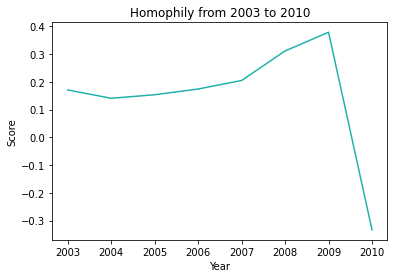

In [25]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title(f"Homophily from 2003 to 2010")
ax.plot([y for y in range(2003, 2011)], homophily.values(), c = "lightseagreen")
plt.ylabel("Score")
plt.xlabel("Year")
plt.show()